<a href="https://colab.research.google.com/github/jacmal/California_Housing_Price_Prediction/blob/main/Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install joblib

#IMPORT LIBS

In [ ]:
from google.colab import files

import pandas as pd
import requests
import io

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

#LOAD DATASET

In [ ]:
url="https://raw.githubusercontent.com/jacmal/California_Housing_Price_Prediction/main/housing.csv"
site = requests.get(url).content

df = pd.read_csv(io.StringIO(site.decode('utf-8')))
df.head(2)

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [ ]:
#create DataFrame copy
housing = df.copy()

#remove 1st column
housing = housing.iloc[:,1:]
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


#DATA SET ANALYSIS 

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


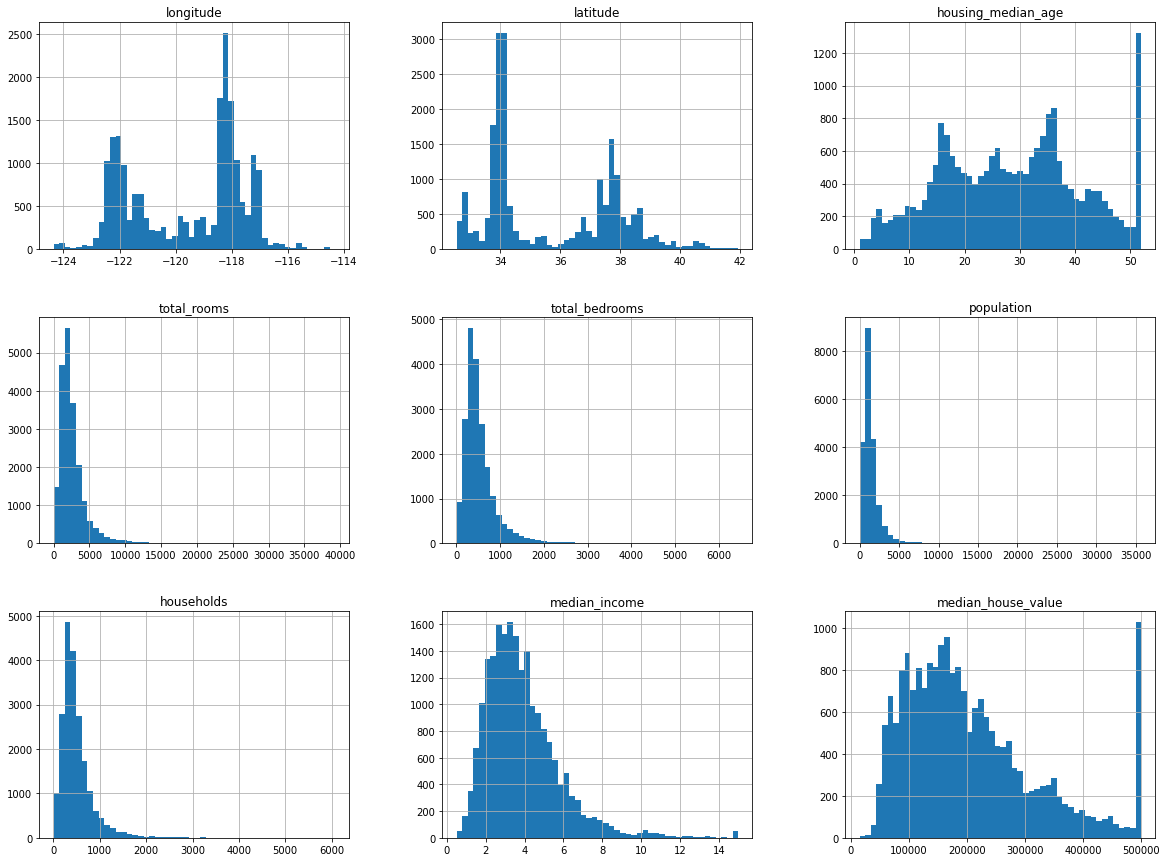

In [ ]:
#create histogram for each numerical feature 
housing.hist(bins=50, figsize=(20,15))
plt.show();

In [ ]:
#create new column with 5 "income_cat"
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], 
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5


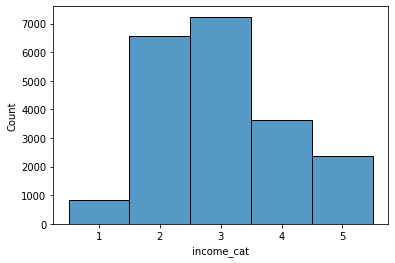

In [ ]:
#"income_cat" histogram
sns.histplot(data = housing["income_cat"]);

#CREATE TRAIN & TEST SET

In [ ]:
#split the dataset keeping the proportions of the 5 income categories
#shuffle data in data sets
split = StratifiedShuffleSplit(n_splits=1, 
                               test_size=0.2, 
                               random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [ ]:
#percentage distribution of 5 income categories in data sets
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
#drop "income_cat" from "strat_train_set" & "strat_test_set"
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
housing = strat_train_set.copy()
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN


#DATA VISUALIZATION

##GEOGRAPHICAL PLOT

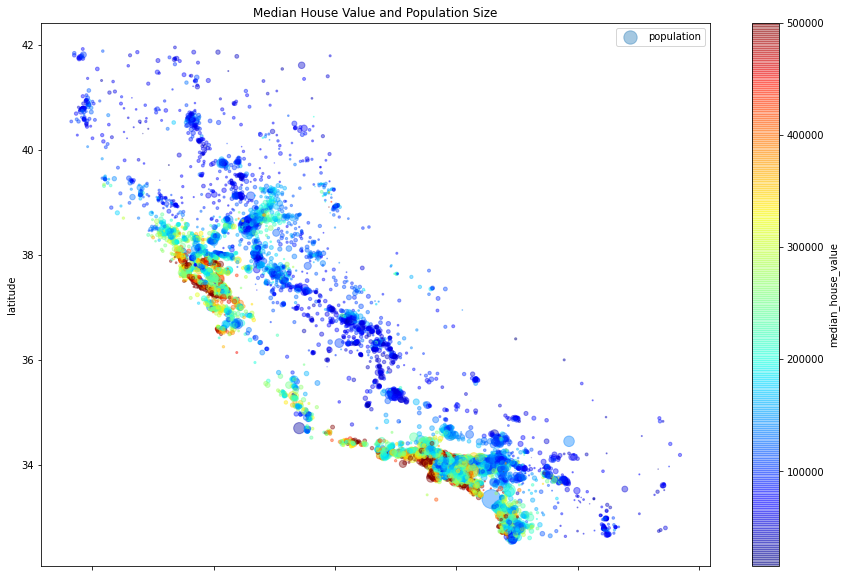

In [ ]:
#create geographical location plot with "median_house_vale" and "population" size
housing.plot(kind="scatter", 
             figsize=(15,10),
             x="longitude", 
             y="latitude", 
             alpha=0.4, 
             s=housing["population"]/100, 
             label="population", 
             c="median_house_value", 
             cmap=plt.get_cmap("jet"), 
             colorbar=True)
plt.title('Median House Value and Population Size')
plt.legend()
plt.show();

#CORRELATIONS CHECKING

In [ ]:
#creating correlations matrix 
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

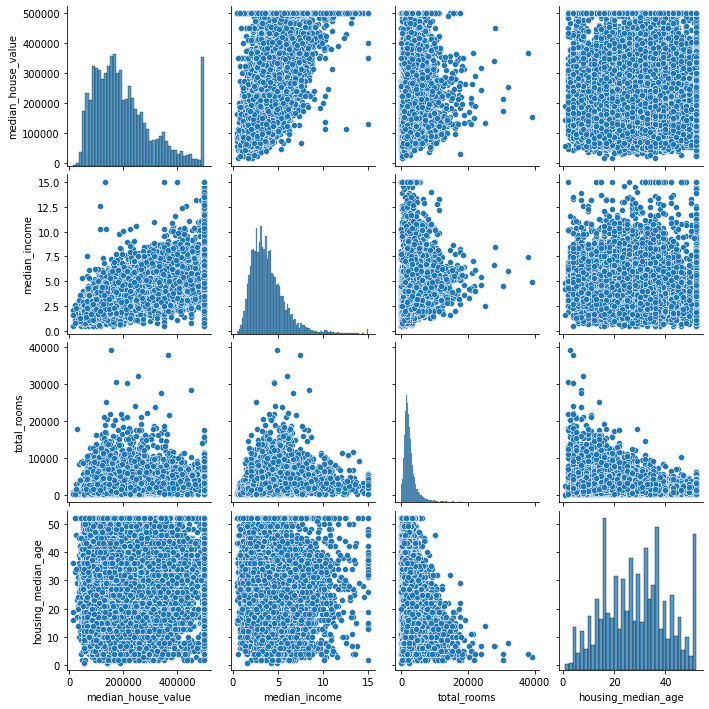

In [ ]:
#creating a pair plot with the 4 highest correlation coefficient
columns_for_plot = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
sns.pairplot(data=housing[columns_for_plot]);

#FEATURES ENGINEERING

In [ ]:
#engineering 3 new features
#housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
#housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
#housing["population_per_household"] = housing["population"]/housing["households"]

In [ ]:
#checking the correlation of new features
#corr_matrix_comb = housing.corr()
#corr_matrix_comb["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

#DATA CLEANING

##Prepare the data for Machine Learning algorithms

In [ ]:
#drop labels for train set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

##Numerical Data

In [ ]:
#data imputer with median strategy
imputer = SimpleImputer(strategy="median")

In [ ]:
#numerical data frame  
housing_num = housing.drop("ocean_proximity", axis=1)

#FEATURES ENGINEERING

##Combined Attributes Adder Class

In [ ]:
#columns indexes for features engineering
rooms_index, bedrooms_index, population_index, households_index = 3, 4, 5, 6

In [ ]:
#

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  #
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  
  #
  def fit(self, X, y=None):
    '''
    Fit features transforamtion.
    '''
    return self
  
  #
  def transform(self, X, y=None):
    '''
    Create new features
    '''
    #
    rooms_per_household = X[:, rooms_index] / X[:, households_index]
    #
    population_per_household = X[:, population_index] / X[:, households_index]
    
    #
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
# ???
#attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
#housing_extra_attribs = attr_adder.transform(housing.values)

##Numerical Pipeline

In [ ]:
#numerical pipeline
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),])

##Creating a full pipeline for data transformation

In [ ]:
#FULL TRANSFORMER PIPELINE
num_attribs = list(housing_num)   
cat_attribs = ["ocean_proximity"] #
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),])

In [ ]:
#encode, imput and transform data with full pipeline
housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared.shape

(16512, 16)

In [ ]:
housing_prepared[0,:]

array([-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
       -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
        0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

#TRAIN A ML MODEL

In [ ]:
#lin_reg = LinearRegression()
#lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#some_data = housing.iloc[:5]
#some_labels = housing_labels.iloc[:5]
#some_data_prepared = full_pipeline.transform(some_data)
#print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


##Creating and Training Random Forest Regressor Model

In [ ]:
#
forest_reg = RandomForestRegressor()
#
forest_reg.fit(housing_prepared, housing_labels)
#
housing_predictions = forest_reg.predict(housing_prepared)

#
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18744.147262276416

In [ ]:
def display_scores(scores):
  '''
  opis
  '''
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [ ]:
#
scores = cross_val_score(forest_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [ ]:
#
display_scores(forest_rmse_scores)

Scores: [49632.3798287  47517.4327098  49781.02566042 52273.9697955
 49821.88495406 53891.65412469 48573.31214089 47817.57120915
 53027.18810915 50518.40249457]
Mean: 50285.48210269333
Standard deviation: 2052.069991209965


#SAVE & LOAD MODEL

In [ ]:
#joblib.dump(forest_reg, "California_Housing_Random_Forest_Regressor.pkl")

#my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
#files.download("California_Housing_Random_Forest_Regressor.pkl")

#ML MODEL HYPERPARAMETERS TUNING

In [ ]:
param_grid = [{'n_estimators': [3, 10, 30],
               'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False],
               'n_estimators': [3, 10],
               'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63455.73307506653 {'max_features': 2, 'n_estimators': 3}
55495.14100740143 {'max_features': 2, 'n_estimators': 10}
53042.85809666149 {'max_features': 2, 'n_estimators': 30}
60905.0104171878 {'max_features': 4, 'n_estimators': 3}
53078.95558027518 {'max_features': 4, 'n_estimators': 10}
50404.331335225535 {'max_features': 4, 'n_estimators': 30}
59202.27448174681 {'max_features': 6, 'n_estimators': 3}
52366.95170771407 {'max_features': 6, 'n_estimators': 10}
50067.49985394241 {'max_features': 6, 'n_estimators': 30}
58358.96447426895 {'max_features': 8, 'n_estimators': 3}
52230.20401487034 {'max_features': 8, 'n_estimators': 10}
50132.22901497509 {'max_features': 8, 'n_estimators': 30}
62499.793451343 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54704.420139479786 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60177.10803536573 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53031.069652096965 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33281219158757086, 'median_income'),
 (0.1529089904949639, 'INLAND'),
 (0.1050723336546328, 'pop_per_hhold'),
 (0.07870661233870126, 'longitude'),
 (0.07106546012857083, 'bedrooms_per_room'),
 (0.06872981025058429, 'latitude'),
 (0.061669112770962035, 'rooms_per_hhold'),
 (0.04233000142640829, 'housing_median_age'),
 (0.01854229363775666, 'total_rooms'),
 (0.01792175933052331, 'population'),
 (0.01664685441802866, 'total_bedrooms'),
 (0.015885485257123334, 'households'),
 (0.009098162821571415, '<1H OCEAN'),
 (0.004562839460442959, 'NEAR OCEAN'),
 (0.003974994307196697, 'NEAR BAY'),
 (7.309811496273844e-05, 'ISLAND')]

In [ ]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2
final_rmse

47932.678266721865

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence,
                         len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors),))

array([45946.88754941, 49839.41027103])